In [16]:
import pandas as pd
import numpy as np

pheno_train = pd.read_csv("train/pheno_training.csv")
pheno_test = pd.read_csv("test/pheno_test.csv")

pheno_train = pheno_train.dropna()
pheno_test = pheno_test.dropna()

## Pré processamento para ML

In [17]:
var = ["Event", "Event_time"]
pheno_train_y = pheno_train.PrevalentHFAIL + pheno_train.Event # data target with the patients that had HF before and after the first data collecting
pheno_train_y = pheno_train_y.map({2: 1, 0: 0, 1: 1}) # make the variable boolean
pheno_train_X = pheno_train.iloc[: , 1:] # Dropping the name of the patients
pheno_train_X = pheno_train_X.drop(columns = ["Event", "Event_time", "PrevalentHFAIL"]) # dropping the variables that we want to predict and event_time doesnt make sense  
pheno_test_y = pheno_test.PrevalentHFAIL + pheno_test.Event # data target with the patients that had HF before and after the first data collecting
pheno_test_y = pheno_test_y.map({2: 1, 0: 0, 1: 1}) # make the variable boolean
pheno_test_X = pheno_test.iloc[: , 1:] # Dropping the name of the patients
pheno_test_X = pheno_test_X.drop(columns = ["Event", "Event_time", "PrevalentHFAIL"]) # dropping the variables that we want to predict and event_time doesnt make sense
# SMOTE -> used for unbalanced data sets 
# Synthetic Minority Over-sampling Technique
from collections import Counter
print('Original dataset shape %s' % Counter(pheno_train_y))
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
pheno_train_X, pheno_train_y = sm.fit_resample(pheno_train_X, pheno_train_y)
print('Resampled dataset shape %s' % Counter(pheno_train_y))
pheno_test_X, pheno_test_y = sm.fit_resample(pheno_test_X, pheno_test_y)


Original dataset shape Counter({0: 3157, 1: 383})
Resampled dataset shape Counter({0: 3157, 1: 3157})


## Modelos de ML
#### Logistic Regression

PECC (accuracy): 0.6446124763705104


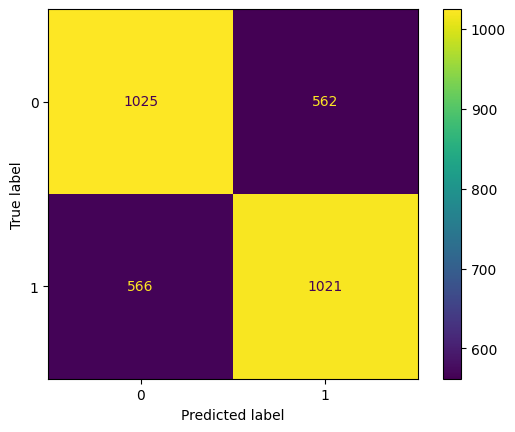

In [18]:
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

logistic = linear_model.LogisticRegression(C=1e5, solver = "liblinear", multi_class = "auto")
logistic = logistic.fit(pheno_train_X, pheno_train_y)
logistic_prev = logistic.predict(pheno_test_X)
print("PECC (accuracy):", accuracy_score(pheno_test_y, logistic_prev))

cm_logreg = confusion_matrix(pheno_test_y, logistic_prev, labels=logistic.classes_)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_logreg, display_labels=logistic.classes_)
disp1.plot()
plt.show()

#### Linear Regression

In [19]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score

regr_model = linear_model.LinearRegression()
regr_model = regr_model.fit(pheno_train_X, pheno_train_y)
regr_model_pred = regr_model.predict(pheno_test_X)

regr_model_pred = np.round(regr_model_pred)

print("PECC (accuracy):", accuracy_score(pheno_test_y, regr_model_pred))

PECC (accuracy): 0.6474480151228733


#### Ridge


In [20]:
ridge = linear_model.Ridge(alpha=.1)
ridge = ridge.fit(pheno_train_X, pheno_train_y)
ridge_pred = ridge.predict(pheno_test_X)
ridge_pred = np.round(ridge_pred)

print("PECC (accuracy):", accuracy_score(pheno_test_y, ridge_pred))

PECC (accuracy): 0.6474480151228733


Lasso

In [21]:
lasso = linear_model.Lasso()
lasso = lasso.fit(pheno_train_X, pheno_train_y)
lasso_pred = lasso.predict(pheno_test_X)
lasso_pred = np.round(lasso_pred)
print("PECC (accuracy):", accuracy_score(pheno_test_y, lasso_pred))


PECC (accuracy): 0.5403276622558286


#### SVM's

In [22]:
from sklearn import svm
from sklearn.model_selection import cross_val_score
SVM = svm.SVC(gamma=0.001, C=100.)
SVM = SVM.fit(pheno_train_X, pheno_train_y)
svm_pred = SVM.predict(pheno_test_X)
print("PECC (accuracy):", accuracy_score(pheno_test_y, svm_pred))
#cross_scores = cross_val_score(SVM, pheno_test_y, svm_pred, cv = 5)
#print(cross_scores)


PECC (accuracy): 0.646817895400126


#### KNeighborsClassifier

In [23]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(pheno_train_X, pheno_train_y)
knn_pred = knn.predict(pheno_test_X)
print("Perc. acertos: ", (knn_pred == pheno_test_y).sum()/len(knn_pred))

Perc. acertos:  0.5214240705734089


#### Decision Tree

Perc. acertos:  0.6887208569628229


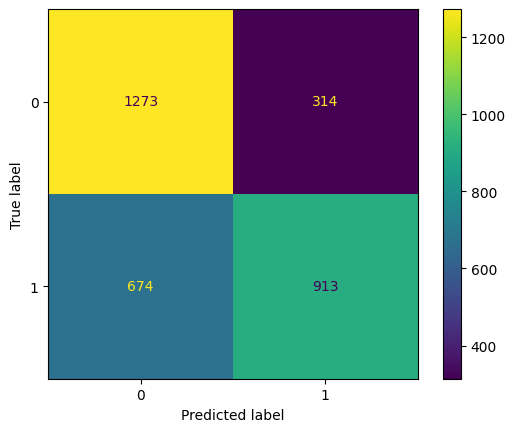

In [24]:
from sklearn import tree
from sklearn.metrics import f1_score

tree_model = tree.DecisionTreeClassifier()
tree_model = tree_model.fit(pheno_train_X, pheno_train_y)
preds_tree = tree_model.predict(pheno_test_X)

print("Perc. acertos: ", (preds_tree == pheno_test_y).sum()/len(preds_tree))

cm_tree = confusion_matrix(pheno_test_y, preds_tree, labels=tree_model.classes_)
disp_tree = ConfusionMatrixDisplay(confusion_matrix=cm_tree, display_labels=tree_model.classes_)
disp_tree.plot()
plt.show()

## Ensembles
#### Voting Classifier

In [26]:
from sklearn.ensemble import VotingClassifier
DTree = tree.DecisionTreeClassifier(max_depth=4)
knn_class = KNeighborsClassifier(n_neighbors=7)
svc = svm.SVC(gamma='scale', kernel='rbf', probability=True)
eclf = VotingClassifier(estimators=[('dt', DTree), ('knn', knn_class), ('svc', svc)], voting='hard')

eclf = eclf.fit(pheno_train_X, pheno_train_y)
print(eclf.score(pheno_test_X, pheno_test_y))

0.6200378071833649
